# Исследование надежности заемщиков

**Описание проекта**:

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели *кредитного скоринга*.

**Оглавление**:
1. Обзор данных
2. Предобработка данных. Пропуски
3. Поиск дубликатов и аномалий
4. Поиск зависимостей возврата кредита от определенных атрибутов "исторических" клиентов
5. Вывод

## Обзор данных

Ознакомимся с данными заказчика:

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Итак, в таблице двенадцать столбцов и 21525 строк:

0. `children` — количество детей в семье
1. `days_employed` — общий трудовой стаж в днях. **Имеются пропуски и отрицательные значения**
2. `dob_years` — возраст клиента в годах
3. `education` — уровень образования клиента
4. `education_id` — идентификатор уровня образования
5. `family_status` — семейное положение
6. `family_status_id` — идентификатор семейного положения
7. `gender` — пол клиента
8. `income_type` — тип занятости
9. `debt` — имел ли задолженность по возврату кредитов
10. `total_income` — ежемесячный доход. **Имеются пропуски**
11. `purpose` — цель получения кредита

**Вывод №1**: На первый взгляд, 
* Не наблюдается нарушение типов данных количественных и качественных переменных;
* Наименования столбцов корректные. Змеиный регистр соблюден;
* Имеются пропущенные значения в столбцах "Трудовой стаж" и "Ежемесячный доход"

## Предобработка данных. Пропуски

Ранее мы обнаружили пропуски в столбцах "Трудовой стаж" и "Ежемесячный доход". Посчитаем пропуски:

In [3]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Ого, одинаковое количество пропусков по двум признакам. Интересно, это одни и те же строки? Но прежде, посмотрим какую долю в % составляют пропущенные значения от общей информации

In [4]:
data.isna().mean().map('{:,.2%}'.format)

children             0.00%
days_employed       10.10%
dob_years            0.00%
education            0.00%
education_id         0.00%
family_status        0.00%
family_status_id     0.00%
gender               0.00%
income_type          0.00%
debt                 0.00%
total_income        10.10%
purpose              0.00%
dtype: object

Пропусков достаточно много. Целых десять процентов. Поэтому не имеем права даже думать об drop. Данные наше всё. Попробуем их сохранить

Интересно, что собой представляют данные с пропусками:

In [5]:
data[data['days_employed'].isna()].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу


In [6]:
data[data['total_income'].isna()].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу


На первый взгляд, пропуски по стажу и доходу по одним и тем же заемщикам/кредитам. Проверим:

In [7]:
if np.prod(data[data['days_employed'].isna()].reset_index()['index'] == \
data[data['total_income'].isna()].reset_index()['index']) == True:
    print('Пропуски по стажу и доходу наблюдаются по одним и тем же заемщикам')
else:
    print('Гипотеза не верна')      

Пропуски по стажу и доходу наблюдаются по одним и тем же заемщикам


В чем причина появлений пропусков? Может пропуски связаны с отсутствием стажа и как следствие отсутствием официального ЗП? Проверим

In [8]:
#вывод типа занятости среди заемщиков с пропуском по стажу и доходу
data[data['days_employed'].isna()]['income_type'].value_counts()

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64

Вряд ли заемщики без стажа и дохода относились бы к типам занятости, подразумевающих белую ЗП. 
Значит пропуски скорее упущения и не связаны с безработными или фрилансерами. Надо заменить на медианные значения. НО прежде прежде поборемся с дубликатами

## Поиск дубликатов и аномалий

In [9]:
# поиск явных дубликатов
data.duplicated().sum()

54

In [10]:
# удаление явных дубликатов
data = data.drop_duplicates().reset_index(drop = True)
data.duplicated().sum()

0


Нашли и удалили 54 явных дубликатов. Не так много, всего лишь 0.25% от общего количества кредитов. Для удаления неявных дубликатов проверим на уникальность содержимое категориальных переменных



### Проверка данных "Дети"

In [11]:
data['children'].value_counts()

 0     14107
 1      4809
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Значения минус 1 и 20. Выведем их на экран. 

Гипотеза: Отрицательное значение может связано с разводами, а дети в количестве 20 штук мошут быть по одному и тому же клиенту

In [12]:
data[data['children'] == -1].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
291,-1,-4417.703588,46,среднее,1,гражданский брак,1,F,сотрудник,0,102816.346412,профильное образование
705,-1,-902.084528,50,среднее,1,женат / замужем,0,F,госслужащий,0,137882.899271,приобретение автомобиля
742,-1,-3174.456205,57,среднее,1,женат / замужем,0,F,сотрудник,0,64268.044444,дополнительное образование
800,-1,349987.852217,54,среднее,1,Не женат / не замужем,4,F,пенсионер,0,86293.724153,дополнительное образование
941,-1,NaN,57,Среднее,1,женат / замужем,0,F,пенсионер,0,NaN,на покупку своего автомобиля


In [13]:
# количество аномалий с -1 ребенком

data[data['children'] == -1]['children'].count()

47

In [14]:
data[data['children'] == 20].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
606,20,-880.221113,21,среднее,1,женат / замужем,0,M,компаньон,0,145334.865002,покупка жилья
720,20,-855.595512,44,среднее,1,женат / замужем,0,F,компаньон,0,112998.738649,покупка недвижимости
1074,20,-3310.411598,56,среднее,1,женат / замужем,0,F,сотрудник,1,229518.537004,получение образования
2510,20,-2714.161249,59,высшее,0,вдовец / вдова,2,F,сотрудник,0,264474.835577,операции с коммерческой недвижимостью
2940,20,-2161.591519,0,среднее,1,женат / замужем,0,F,сотрудник,0,199739.941398,на покупку автомобиля


In [15]:
# количество аномалий с 20-ью детьми

data[data['children'] == 20]['children'].count()

76

Гипотезы не подтвердились. Аномалию по кол-ву детей в -1 и 20 в силу их небольшого количества удалим (0.6%). Если их было бы больше, то можно было бы строить дополнительные гипотезы 

In [16]:
data = data[(data['children'] != -1) & (data['children'] != 20)]

In [17]:
# проверим отсутствие устраненных аномалий
data['children'].value_counts()

0    14107
1     4809
2     2052
3      330
4       41
5        9
Name: children, dtype: int64

### Проверка данных "Возраст клиента"

Просмотрим список значений по списку возраст:

<AxesSubplot:>

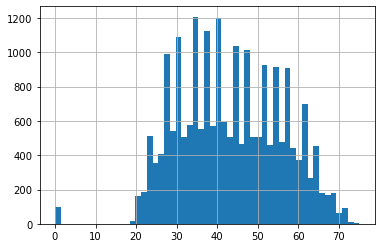

In [18]:
data['dob_years'].hist(bins = 'auto')

Имеется нулевое значение возраста. Проверим их количество

In [19]:
data[data['dob_years'] == 0]['dob_years'].count()

100

Обнаружили нулевые значения возраста 
> ***ЗАМЕТКА №1*** Заменить нулевые значения на медиану после исключения дубликатов. Так будет правильнее.
Далее проверим стаж работы. К возрасту еще вернемся.


### Проверка данных "Стаж работы"

In [20]:
data['days_employed'].head()

0     -8437.673028
1     -4024.803754
2     -5623.422610
3     -4124.747207
4    340266.072047
Name: days_employed, dtype: float64

Как ранее заметили, имеются отрицательные значения в столбце стаж. Посчитаем количество отрицательных значений по столбцу "стаж"

In [21]:
len(data[data['days_employed'] < 0])

15809

Отрицательных значений достаточно много. Скорее всего дефис перепутан с минусом.
Заполним ячейки модулем значений.

In [22]:
# переод всех значений стажа в положительное значение 
data['days_employed'] = abs(data['days_employed'])
# проверка отсутствия отрицательных значений
len(data[data['days_employed'] < 0])

0

Успешно заменили отрицательные значения на положительные. 


Проверим на наличие аномалий по длительности стажа по условию, что стаж не может превышать возраст. Но прежде стаж для удобства переведем в годы

In [23]:
# Добавление столбца стажа в годах
years_employed_data = round(data['days_employed'] / 365, 2)
data.insert(2, 'years_employed', years_employed_data, False)

# Удаление столбца стажа в днях
del data['days_employed']
data.head()

,children,years_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,23.12,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,11.03,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,15.41,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,11.30,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,932.24,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [24]:
# проверка аномалий по превышению возраста стажом
data[data['years_employed'] >= data['dob_years']].head()

,children,years_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
4,0,932.24,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
18,0,1096.66,53,среднее,1,вдовец / вдова,2,F,пенсионер,0,56823.777243,на покупку подержанного автомобиля
24,1,927.54,57,среднее,1,Не женат / не замужем,4,F,пенсионер,0,290547.235997,операции с коммерческой недвижимостью
25,0,996.02,67,среднее,1,женат / замужем,0,M,пенсионер,0,55112.757732,покупка недвижимости
30,1,919.40,62,среднее,1,женат / замужем,0,F,пенсионер,0,171456.067993,операции с коммерческой недвижимостью


Кого собой представляют клиенты с аномалией по стажу?

In [25]:
data[data['years_employed'] >= data['dob_years']]['income_type'].value_counts()

пенсионер      3429
сотрудник        49
компаньон        18
госслужащий       6
безработный       2
Name: income_type, dtype: int64

У 3,5 тысячам кредитов аномалия по стажу работы (превышают их возраст). 

Кто они? Большинсто заемщиков с аномальным стажем это пенсионеры.

Можно заменить аномалии медианой всей выборки, однако это скорее будет неверно, так как у большинства пенсионеров стаж может быть приостановлен. Правильнее было бы провести расчет привязываясь к возрасту выхода на пенсию по гендеру и к возрасту окончания образования. Однако не факт, что на протяжении всего этого периода люди работали.

Стоит отметить, что заказчика не интересует исследование влияния стажа на возврат кредита в срок. Поэтому к вопросу можно будет вернуться позже. Например, после уточнения источника данных и установления корневых причин данной аномалии. 

Поэтому на сей раз, приведем в порядок столбец со стажем "для галочки". Не более. 

>  ***Заметка №2*** Предлагаю заменить пустыми значениями, а после удаления неявных дубликатов, заменить их на медиану.

In [26]:
data.loc[data['years_employed'] >= data['dob_years'], 'years_employed'] = None 
data.head()

,children,years_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,23.12,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,11.03,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,15.41,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,11.30,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,NaN,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


### Проверка данных "Образование"

In [27]:
data.groupby(['education','education_id']).agg({'education_id':'count'})

,,education_id
education,education_id,
ВЫСШЕЕ,0,270
Высшее,0,268
НАЧАЛЬНОЕ,3,17
НЕОКОНЧЕННОЕ ВЫСШЕЕ,2,29
Начальное,3,15
Неоконченное высшее,2,47
СРЕДНЕЕ,1,766
Среднее,1,703
УЧЕНАЯ СТЕПЕНЬ,4,1


Можем ограничиться приведением в нижний регистр

In [28]:
data['education'] = data['education'].str.lower()
data.groupby(['education','education_id']).agg({'education_id':'count'})

,,education_id
education,education_id,
высшее,0,5228
начальное,3,282
неоконченное высшее,2,741
среднее,1,15091
ученая степень,4,6


<div class="alert alert-block alert-success">
<b>Успех:</b> Здорово, что используешь строковые методы, это полезный инструмент.
</div>

id присвоены корректно

Создадим новый датафрейм по образованию и оставим в основном датафрейме только id

In [29]:
education_data = pd.DataFrame(data = [
                                  [0, 'высшее'], 
                                  [1, 'среднее'], 
                                  [2, 'неоконченное высшее'],
                                  [3, 'начальное'], 
                                  [4, 'ученая степень']],
                                   columns = ['education_id', 'education'])
education_data

,education_id,education
0,0,высшее
1,1,среднее
2,2,неоконченное высшее
3,3,начальное
4,4,ученая степень


In [30]:
del data['education']
data.head()

,children,years_employed,dob_years,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,23.12,42,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,11.03,36,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,15.41,33,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,11.30,32,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,NaN,53,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


### Проверка данных "Семейное положение"

In [31]:
data.groupby(['family_status','family_status_id']).agg({'family_status_id':'count'})

,,family_status_id
family_status,family_status_id,
Не женат / не замужем,4,2796
в разводе,3,1189
вдовец / вдова,2,951
гражданский брак,1,4146
женат / замужем,0,12266


id присвоены корректно

Создадим новый датафрейм по семейному положению и оставим в основном датафрейме только id

In [32]:
family_status_data = pd.DataFrame(data = [
                                  [0, 'женат / замужем'], 
                                  [1, 'гражданский брак'], 
                                  [2, 'вдовец / вдова'],
                                  [3, 'в разводе'], 
                                  [4, 'Не женат / не замужем']],
                                   columns = ['family_status_id', 'family_status'])
family_status_data

,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,Не женат / не замужем


In [33]:
del data['family_status']
data.head()

,children,years_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose
0,1,23.12,42,0,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,11.03,36,1,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,15.41,33,1,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,11.30,32,1,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,NaN,53,1,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Отлично. Столбец лишний удален. Идем дальше

### Проверка данных "Пол клиента"

In [34]:
data['gender'].value_counts()

F      14107
M       7240
XNA        1
Name: gender, dtype: int64

Удалим клиента с гендером XNA

In [35]:
data = data[data['gender'] != 'XNA']
data['gender'].value_counts()

F    14107
M     7240
Name: gender, dtype: int64

### Проверка данных "Тип занятости"

In [36]:
data['income_type'].value_counts()

сотрудник          11022
компаньон           5048
пенсионер           3820
госслужащий         1451
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

Отлично. Неявных дубликатов нет

### Проверка данных "Наличие задолженности"

In [37]:
data['debt'].value_counts()

0    19615
1     1732
Name: debt, dtype: int64

Аномалий отсутствуют

### Категоризация "Целей получения кредита". 

In [38]:
data['purpose'].value_counts()

свадьба                                   792
на проведение свадьбы                     768
сыграть свадьбу                           764
операции с недвижимостью                  672
покупка коммерческой недвижимости         659
покупка жилья для сдачи                   650
операции с жильем                         647
операции с коммерческой недвижимостью     645
жилье                                     641
покупка жилья                             640
покупка жилья для семьи                   637
недвижимость                              631
строительство собственной недвижимости    628
операции со своей недвижимостью           623
строительство жилой недвижимости          621
строительство недвижимости                619
покупка своего жилья                      619
покупка недвижимости                      615
ремонт жилью                              604
покупка жилой недвижимости                602
на покупку своего автомобиля              504
заняться высшим образованием      

Создадим функцию под категоризацию целей получения кредита. Для этого разделим их на четыре категории:

In [39]:
def purpose_category(row):
    auto = ['на покупку своего автомобиля', 'автомобиль', 
        'сделка с подержанным автомобилем', 'свой автомобиль',
       'на покупку подержанного автомобиля', 'автомобили', 
        'на покупку автомобиля', 'сделка с автомобилем', 'приобретение автомобиля']
    realty = ['операции с недвижимостью', 'покупка коммерческой недвижимости', 
          'покупка жилья для сдачи', 'операции с жильем', 
          'операции с коммерческой недвижимостью',
          'жилье', 'покупка жилья', 'покупка жилья для семьи', 
          'строительство собственной недвижимости',
          'недвижимость','операции со своей недвижимостью',
          'строительство жилой недвижимости',
          'покупка недвижимости', 'покупка своего жилья', 
          'строительство недвижимости', 'ремонт жилью', 
          'покупка жилой недвижимости']
    marriage = ['свадьба', 'на проведение свадьбы', 'сыграть свадьбу', ]
    education = ['дополнительное образование', 'заняться высшим образованием',
             'высшее образование', 'образование', 'получение дополнительного образования', 
             'получение образования', 'профильное образование', 'заняться образованием',
             'получение высшего образования']
    try:
        if row['purpose'] in auto:
            return 'операции с автомобилем'
        elif row['purpose'] in realty:
            return 'операции с недвижимостью'
        elif row['purpose'] in marriage:
            return 'проведение свадьбы'
        elif row['purpose'] in education:
            return 'получение образования'
    except:
        return row['purpose']

data['purpose_category'] = data.apply(purpose_category, axis = 1)
data.head()

,children,years_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category
0,1,23.12,42,0,0,F,сотрудник,0,253875.639453,покупка жилья,операции с недвижимостью
1,1,11.03,36,1,0,F,сотрудник,0,112080.014102,приобретение автомобиля,операции с автомобилем
2,0,15.41,33,1,0,M,сотрудник,0,145885.952297,покупка жилья,операции с недвижимостью
3,3,11.30,32,1,0,M,сотрудник,0,267628.550329,дополнительное образование,получение образования
4,0,NaN,53,1,1,F,пенсионер,0,158616.077870,сыграть свадьбу,проведение свадьбы


In [40]:
# проверим уникальность значений после категоризации
data['purpose_category'].value_counts()

операции с недвижимостью    10753
операции с автомобилем       4281
получение образования        3989
проведение свадьбы           2324
Name: purpose_category, dtype: int64

Добавили новый столбец c категориями "цели получения кредита".

Столбец purpose больше нам не понадобится. Будет только мешать при поиске неявных дубликатов - вдруг один и тот же заемщик дублируется с разной формулировкой целей получения кредита.

In [41]:
del data['purpose']
data.head()

,children,years_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose_category
0,1,23.12,42,0,0,F,сотрудник,0,253875.639453,операции с недвижимостью
1,1,11.03,36,1,0,F,сотрудник,0,112080.014102,операции с автомобилем
2,0,15.41,33,1,0,M,сотрудник,0,145885.952297,операции с недвижимостью
3,3,11.30,32,1,0,M,сотрудник,0,267628.550329,получение образования
4,0,NaN,53,1,1,F,пенсионер,0,158616.077870,проведение свадьбы


### Удаление неявных дубликатов

In [42]:
data.duplicated().sum()

351

Дополнительно выявлены 351 дубликатов, не так много. 
Удалим дубликаты

In [43]:
data = data.drop_duplicates().reset_index(drop = True)
data

,children,years_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose_category
0,1,23.12,42,0,0,F,сотрудник,0,253875.639453,операции с недвижимостью
1,1,11.03,36,1,0,F,сотрудник,0,112080.014102,операции с автомобилем
2,0,15.41,33,1,0,M,сотрудник,0,145885.952297,операции с недвижимостью
3,3,11.30,32,1,0,M,сотрудник,0,267628.550329,получение образования
4,0,NaN,53,1,1,F,пенсионер,0,158616.077870,проведение свадьбы
...,...,...,...,...,...,...,...,...,...,...
20991,1,12.41,43,1,1,F,компаньон,0,224791.862382,операции с недвижимостью
20992,0,NaN,67,1,0,F,пенсионер,0,155999.806512,операции с автомобилем
20993,1,5.79,38,1,1,M,сотрудник,1,89672.561153,операции с недвижимостью
20994,3,8.53,38,1,0,M,сотрудник,1,244093.050500,операции с автомобилем


In [44]:
# проверка отсутствия дубликатов
data.duplicated().sum()

0

Теперь вернемся к ранее записанным заметкам

### "Заполнение пропусков" 

С целью сохранения данных заменим пропущенные значения на медианные. Так мы искусственно не будем смещать кривую распределения количественных переменных по стажу, доходу и возрасту, а так же не будем учитывать единичные выбросы.

In [45]:
#найдем медиану по стажу
years_employed_meadian = round(data['years_employed'].median() , 2)
years_employed_meadian

4.47

In [46]:
#найдем медиану по ежемесячному доходу
total_income_meadian = int(data['total_income'].median())
total_income_meadian

145017

In [47]:
#найдем медиану возраста
total_dob_years = int(data['dob_years'].median())
total_dob_years

42

Медиана стажа клиентов составляет 13 лет, что говорит о том, что кредит банки охотно выдают людям с большим стажем, а может быть, что кредит молодое поколение не берет и больше склонна к уберизации...

In [48]:
# заменим пропущенные значения
data['years_employed'] = data['years_employed'].fillna(years_employed_meadian)
data['total_income'] = data['total_income'].fillna(total_income_meadian)
data['dob_years'] = data['dob_years'].fillna(total_dob_years)

# проверим отсутствие пропусков
data.isna().sum()

children            0
years_employed      0
dob_years           0
education_id        0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose_category    0
dtype: int64

Сдержали обещания. Пропуски устранены 

### Класификация "Ежемесячных доходов"

In [49]:
# округлим доходы
data['total_income'] = data['total_income'].astype('int')
data

,children,years_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose_category
0,1,23.12,42,0,0,F,сотрудник,0,253875,операции с недвижимостью
1,1,11.03,36,1,0,F,сотрудник,0,112080,операции с автомобилем
2,0,15.41,33,1,0,M,сотрудник,0,145885,операции с недвижимостью
3,3,11.30,32,1,0,M,сотрудник,0,267628,получение образования
4,0,4.47,53,1,1,F,пенсионер,0,158616,проведение свадьбы
...,...,...,...,...,...,...,...,...,...,...
20991,1,12.41,43,1,1,F,компаньон,0,224791,операции с недвижимостью
20992,0,4.47,67,1,0,F,пенсионер,0,155999,операции с автомобилем
20993,1,5.79,38,1,1,M,сотрудник,1,89672,операции с недвижимостью
20994,3,8.53,38,1,0,M,сотрудник,1,244093,операции с автомобилем


In [50]:
#разделим доходы на пять категорий. Напишем функцию "классификатор"
def income_category(row):
    try:
        if row['total_income'] >= 1000001:
            return 'A'
        elif row['total_income'] >= 200001:
            return 'B'
        elif row['total_income'] >= 50001:
            return 'C'
        elif row['total_income'] >= 30001:
            return 'D'
        elif row['total_income'] >= 0:
            return 'E'
    except:
        return 'ошибка'
        
data['total_income_category'] = data.apply(income_category, axis = 1)
del data['total_income']
data['total_income_category'].value_counts()

C    15588
B     5012
D      349
A       25
E       22
Name: total_income_category, dtype: int64

### DataFrame после предобработки данных

In [51]:
data.head()

,children,years_employed,dob_years,education_id,family_status_id,gender,income_type,debt,purpose_category,total_income_category
0,1,23.12,42,0,0,F,сотрудник,0,операции с недвижимостью,B
1,1,11.03,36,1,0,F,сотрудник,0,операции с автомобилем,C
2,0,15.41,33,1,0,M,сотрудник,0,операции с недвижимостью,C
3,3,11.30,32,1,0,M,сотрудник,0,получение образования,B
4,0,4.47,53,1,1,F,пенсионер,0,проведение свадьбы,C


## Поиск зависимостей возврата кредита от определенных атрибутов "исторических" клиентов

### Есть ли зависимость между количеством детей и возвратом кредита в срок?

In [52]:
data.groupby(['children'])['debt'].mean()

children
0    0.076728
1    0.093454
2    0.095145
3    0.082067
4    0.100000
5    0.000000
Name: debt, dtype: float64

***Вывод:*** 

Средняя доля должников колеблется в диапазоне 7.6 - 10 %


Однозначно можно утверждать, что клиенты без детей меньше нарушают сроки кредита (7.6 %).

### Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [53]:
# Разобъем клиентов по семейному положению
# Определим общее количество клиентов по каждой группе и кол-во клиентов с репутацией должника
agg_func_math = {'debt': ['sum', 'count']}
repayment_rate_family = data.groupby(['family_status_id']).agg(agg_func_math)
# определим долю должников по каждой из групп
repayment_rate_family['debt_percent'] = round(repayment_rate_family['debt', 'sum'] / repayment_rate_family['debt', 'count'] * 100 , 1)
repayment_rate_family.insert(0, 'family_status', family_status_data['family_status'], False)
repayment_rate_family

family_status debt        debt_percent
                                         sum  count             
family_status_id                                                
0                       женат / замужем  925  11998          7.7
1                      гражданский брак  385   4106          9.4
2                        вдовец / вдова   63    935          6.7
3                             в разводе   84   1187          7.1
4                 Не женат / не замужем  273   2770          9.9

***Вывод:*** 

Люди в гражданском браке, а также неженатые и незамужние более подвержены к просрочке кредита. Доля должников - 9-10%

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [54]:
# Разобъем клиентов по категории дохода. 
# Определим общее количество клиентов по каждой группе и кол-во клиентов с репутацией должника
agg_func_math = {'debt': ['sum', 'count']}
repayment_rate_income = data.groupby(['total_income_category']).agg(agg_func_math)
# определим долю должников по каждой из групп
repayment_rate_income['debt_percent'] = round(repayment_rate_income['debt', 'sum'] / repayment_rate_income['debt', 'count'] * 100 , 1)
repayment_rate_income

debt        debt_percent
                        sum  count             
total_income_category                          
A                         2     25          8.0
B                       354   5012          7.1
C                      1351  15588          8.7
D                        21    349          6.0
E                         2     22          9.1

***Вывод:*** 

Нет прямой корелляции между доходом клиента и количеством должников. Скорее богатые так же могут нарушать сроки возврата из-за больших объемов кредитных средств. Жаль, что нам недоступны объемы кредитного долга клиентов. Меньше всего должников в срезе ежемесячного дохода 30 - 50 тр

### Как разные цели кредита влияют на его возврат в срок?

In [55]:
# Разобъем клиентов по целям получения кредита
# Определим общее количество клиентов по каждой группе и кол-во клиентов с репутацией должника
agg_func_math = {'debt': ['sum', 'count']}
repayment_rate_purpose = data.groupby(['purpose_category']).agg(agg_func_math)
# определим долю должников по каждой из групп
repayment_rate_purpose['debt_percent'] = round(repayment_rate_purpose['debt', 'sum'] / repayment_rate_purpose['debt', 'count'] * 100 , 1)
repayment_rate_purpose

debt        debt_percent
                          sum  count             
purpose_category                                 
операции с автомобилем    399   4245          9.4
операции с недвижимостью  779  10517          7.4
получение образования     369   3939          9.4
проведение свадьбы        183   2295          8.0

***Вывод:*** 

Должников меньше всего среди клиентов, получивших под цели операций с недвижимостью

### Как разные типы занятости влияют на его возврат в срок?

In [56]:
# Разобъем клиентов по категории типа занятости. 
# Определим общее количество клиентов по каждой группе и кол-во клиентов с репутацией должника
agg_func_math = {'debt': ['sum', 'count']}
repayment_rate_type = data.groupby(['income_type']).agg(agg_func_math)
# определим долю должников по каждой из групп
repayment_rate_type['debt_percent'] = round(repayment_rate_type['debt', 'sum'] / repayment_rate_type['debt', 'count'] * 100 , 1)
repayment_rate_type

debt        debt_percent
                  sum  count             
income_type                              
безработный         1      2         50.0
в декрете           1      1        100.0
госслужащий        86   1444          6.0
компаньон         374   5001          7.5
пенсионер         216   3715          5.8
предприниматель     0      2          0.0
сотрудник        1052  10830          9.7
студент             0      1          0.0

***Вывод:*** 

Должников меньше всего среди пенсионеров и госслужащих. Доля должников 6%

### Как уровень образования влияет на возврат кредита в срок?

In [57]:
# Разобъем клиентов по категории образования. 
# Определим общее количество клиентов по каждой группе и кол-во клиентов с репутацией должника
agg_func_math = {'debt': ['sum', 'count']}
repayment_rate_education = data.groupby(['education_id']).agg(agg_func_math)
# определим долю должников по каждой из групп
repayment_rate_education['debt_percent'] = round(repayment_rate_education['debt', 'sum'] / repayment_rate_education['debt', 'count'] * 100 , 1)
repayment_rate_education.insert(0, 'education', education_data['education'], False)
repayment_rate_education

education  debt        debt_percent
                                    sum  count             
education_id                                               
0                          высшее   278   5189          5.4
1                         среднее  1353  14779          9.2
2             неоконченное высшее    68    740          9.2
3                       начальное    31    282         11.0
4                  ученая степень     0      6          0.0

***Вывод:*** 

Меньше всего должников среди клиентов с высшим образованием. Причем значитально. Имеется корелляция относительно уровня образования клиента, если не учитывать разницу в количестве выборки. Заказчику стоит на это обратить внимание.

### Портрет идеального клиента

 “Портрет” идеального клиента для банка с точки зрения отсутствия просрочек: это однозначно человек с высшим образованием, госслужащий или пенсионер, получающий кредит под цели операций с недвижимостью, не неженатый/незамужняя и не в гражданском браке. Как много таких людей в массиве данных?

In [58]:
best_clients = data.loc[ 
    (data['education_id'] == 0) & 
    (data['income_type'].isin(['госслужащий', 'пенсионер'])) & 
    (data['purpose_category'] == 'операции с недвижимостью') &
    (data['family_status_id'].isin([0, 2, 3]))
     ]
len(best_clients)


477

In [59]:
'Доля должников среди "идеальных" клиентов {:.1%}'.format(best_clients['debt'].sum() / best_clients['debt'].count())

'Доля должников среди "идеальных" клиентов 4.0%'

Заказчику стоит задуматься над тем, чтобы привлекать клиентов описанных выше. В среднем доля должников сильно меньше ранее изученных зависимостей и составляет 4%, однако и выборка небольшая - 2.5 % от всего количества клиентов.

## Вывод

Выводы по предобработке данных:

- Заказчиком предоставлен достаточно большой массив данных клиентов. До удаления дубликатов 21 524 кредитов под разные цели. При условии, что клиенты не одни и те же люди это практически население небольшого поселка.
- Среди данных обнаружены пропущенные значения по стажу и доходам в количестве 2174 штук. Это практически 10% от всей информации. Пропуски по одним и тем кредитам/ заемщикам, и как оказалось никак не связаны с безработными.
- Количество явных дубликатов 54 штук (0.25 % от общей информации). Удалены.


Аномалии:
1. Имеются заемщики с отрицательным количеством детей (-1) и с 20-ю. Их количество небольшое (0.6%). Удалены. 
2. Имеются нулевые значения возраста (100 шт). Заменены на медиану после исключения неявных дубликатов.
3. Три четверти данных содержат отрицательный стаж клиентов. Вероятно минус перепутан со знаком дефиса. По 3.5 тысячам кредитам стаж работы клиентов превышает их возраст. Аномалия представлена практически только по пенсионерам. Заменены “для галочки” на медиану после исключения неявных дубликатов.
4. Удален клиент с гендером XNA.

- Данные по образованию приведены в нижний регистр и этого было достаточно для их категоризации.
- Ранее присвоенные id в данных Заказчика как по образованию, так и по семейному положению корректные.
- После вышекузанной работы определены неявные дубликаты в количестве 351 штук.
- Пропущенные значения по стажу, доходу, нулевой возраст заменены на медианные значения.

__Результаты исследования для скоринговой системы:__

- Зависимость между количеством детей и возвратом кредита в срок отсутствует. Средняя доля должников колеблется в диапазоне 8 - 11 %
- Люди в разводе, а также вдовы/вдовцы менее подвержены к просрочке кредита. Доля должников - 7%. Однако это может быть связано с меньшим количеством выборки. Незамужние и неженатые клиенты более подвержены к просрочке кредита. Доля должников - 10%.
- Нет прямой корелляции между доходом клиента и количеством должников. Может стоило дробить доходы с меньшим шагом. Люди в достатке так же могут нарушать сроки кредита из-за больших объемов кредитных средств. Жаль, что нам недоступны объемы кредитного долга клиентов. Меньше всего должников в срезе ежемесячного дохода от 30 тр до 50 тр.
- Должников меньше всего среди клиентов, получавших кредит под цели операций с недвижимостью.
- Должников меньше всего среди пенсионеров и госслужащих. Доля должников 6%
- Меньше всего должников среди клиентов с высшим образованием. Доля должников 5%. Причем значительно ниже от другой страты населения, по которым доля колеблется в районе 10%. Заказчику стоит на это обратить внимание.
- ”Портрет” идеального клиента для банка с точки зрения отсутствия просрочек: это однозначно человек с высшим образованием, госслужащий или пенсионер, получающий кредит под цели операций с недвижимостью, неженатый и незамужняя и не в гражданском браке
- Заказчику стоит задуматься над тем, чтобы привлекать клиентов описанных выше. В среднем доля должников сильно меньше и составляет 4%, однако и выборка небольшая - 2.5 % от всего количества клиентов. Поэтому это рекомендация нисколько к выбору клиента, сколько к приоритизации и составлению рейтинга потенцаильного "добросовестного" заемщика.

Факты:
- Факт №1. Две трети заемщиков без детей
- Факт №2. Самая популярная категория, как и ожидалось - это “недвижимость”. Практически половина кредитов выдана под операции с недвижимостью.
- Факт №3. Большинство клиентов (75%) имеют доход от 50 до 200 тр. Вероятно это связано с уровнем ЗП и ее распределением в целом у населения.